In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
import statistics
from tqdm import tqdm_notebook
import re
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding, LSTM, Bidirectional
from keras.layers.merge import Concatenate
from keras.datasets import imdb
from keras.preprocessing import sequence
import numpy as np
np.random.seed(0)

D:\Users\BULLET\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [133]:
train_data = pd.read_csv("train_F3WbcTw.csv")
test_data = pd.read_csv("test_tOlRoBf.csv")

In [27]:
train_data.head()

,unique_hash,text,drug,sentiment
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,Autoimmune diseases tend to come in clusters. ...,gilenya,2
1,9eba8f80e7e20f3a2f48685530748fbfa95943e4,I can completely understand why you’d want to ...,gilenya,2
2,fe809672251f6bd0d986e00380f48d047c7e7b76,Interesting that it only targets S1P-1/5 recep...,fingolimod,2
3,bd22104dfa9ec80db4099523e03fae7a52735eb6,"Very interesting, grand merci. Now I wonder wh...",ocrevus,2
4,b227688381f9b25e5b65109dd00f7f895e838249,"Hi everybody, My latest MRI results for Brain ...",gilenya,1


In [28]:
# data['text'][27]

In [29]:
# plt.hist([len(train_data['text'].iloc[line].split()) for line in range(0,len(train_data))],bins=5000)
# plt.show()

In [134]:
print(max([len(train_data['text'].iloc[line].split()) for line in range(0,len(train_data))]))

19614


In [135]:
print("Mean length of the sentences:",statistics.mean([len(train_data['text'].iloc[line].split()) for line in range(0,len(train_data))]))

Mean length of the sentences: 341.40178064027276


In [136]:
# data['text'][27]

In [137]:
def preprocessing(data):
    sentences = list(data['text'])
    for line in tqdm_notebook(range(len(sentences))):
        sentence = sentences[line].lower().split()
        new_sentence = []
        for i in range(len(sentence)):
            if "http:" in sentence[i] or "https:" in sentence[i]:
                continue
            else:
                new_sentence.append(sentence[i])
        sentences[line] = " ".join(new_sentence)
    data['text'] = sentences
    def clean_str1(string):
        string = re.sub(r"[a-z]+:", "", string)
        string = re.sub(r"\S+@\S+", "", string)
        string = re.sub(r":[a-z]+", "", string)
        string = re.sub(r"(^|[^@\w])@(\w{1,15})\b", "", string)
        string = re.sub(r"[»]", "", string)
    #     string = re.sub(r"[.]{2,}", " ", string)
#         string = re.sub(r'\([^()]*\)', "", string)
        string = re.sub(r'[a-z]{3}\s[a-z]{3}\s\d{2}\,\s\d{4}\s\d{1,2}\:\d{2}\s[a-z]{2}', "", string) #for removing timestamp
        string = re.sub(r"[^A-Za-z0-9()\'\`\’\.\?]", " ", string)
        string = re.sub(r"[\’]","'",string)
#         string = re.sub(r"\'s", " \'s", string)
#         string = re.sub(r"\'ve", " \'ve", string)
#         string = re.sub(r"n\'t", " n\'t", string)
#         string = re.sub(r"\'re", " \'re", string)
#         string = re.sub(r"\'d", " \'d", string)
#         string = re.sub(r"\'ll", " \'ll", string)
    #     string = re.sub(r"!", " ! ", string)
#         string = re.sub(r"\(", " \( ", string)
#         string = re.sub(r"\)", " \) ", string)
    #     string = re.sub(r"\?", " \? ", string)
        string = re.sub(r"\s{2,}", " ", string)
        return string
    data['text'] = [clean_str1(data['text'].iloc[line]) for line in range(len(data))]
#     sentences = list(data['text'])
#     for line in tqdm_notebook(range(len(sentences))):
#         sentence = sentences[line].split()
#         new_sentence = []
#         for i in range(len(sentence)):
#             if sentence[i].isdigit():
#                 continue
#             else:
#                 new_sentence.append(sentence[i])
#         sentences[line] = " ".join(new_sentence)
#     data['text'] = sentences
    return data

In [138]:
train_data = preprocessing(train_data)
test_data = preprocessing(test_data)

In [139]:
# plt.hist([len(train_data['text'].iloc[line].split()) for line in range(0,len(train_data))],bins=5000)
# plt.show()

In [140]:
print(max([len(train_data['text'].iloc[line].split()) for line in range(0,len(train_data))]))

20068


In [141]:
print("Mean length of the sentences:",statistics.mean([len(train_data['text'].iloc[line].split()) for line in range(0,len(train_data))]))

Mean length of the sentences: 344.40272778935406


In [142]:
print("Mean length of the sentences:",statistics.mean([len(test_data['text'].iloc[line].split()) for line in range(0,len(test_data))]))
print(max([len(test_data['text'].iloc[line].split()) for line in range(0,len(test_data))]))
test_mean_length = 375

Mean length of the sentences: 400.8515731874145
33300


In [15]:
train_data.shape, test_data.shape

((5279, 4), (2924, 3))

In [145]:
train_data.to_csv("train_data_1.csv",sep=",",index=None)
test_data.to_csv("test_data_1.csv",sep=",",index=None)

In [144]:
train_data.text[5]

"i can't give you advice about lemtrada because i chose cladribine. have you thought about this drug? the doctors at barts are keen to give it to people with spms. you can read about it "

In [16]:
train0 = train_data[train_data.sentiment == 0]
train1 = train_data[train_data.sentiment == 1]
train2 = train_data[train_data.sentiment == 2].iloc[0:1000]
del train_data
train0 = train0.append(train1)
train0 = train0.append(train2)
train_data = train0.copy()
del train0
del train1
del train2

In [17]:
corpus = []
for line in range(len(train_data)):
    corpus.append(train_data['text'].iloc[line].split())
for line in range(len(test_data)):
    corpus.append(test_data['text'].iloc[line].split())

In [18]:
def pad_sentences(sentences, padding_word="<PAD/>"):
    """
    Pads all sentences to the same length. The length is defined by the longest sentence.
    Returns padded sentences.
    """
    sequence_length = max(len(x) for x in sentences)
#     sequence_length = 375 
    padded_sentences = []
    for i in range(len(sentences)):
        sentence = sentences[i]
        num_padding = sequence_length - len(sentence)
        new_sentence = sentence + [padding_word] * num_padding
        padded_sentences.append(new_sentence)
    return padded_sentences

In [19]:
import itertools
from collections import Counter

def build_vocab(sentences):
    """
    Builds a vocabulary mapping from word to index based on the sentences.
    Returns vocabulary mapping and inverse vocabulary mapping.
    """
    # Build vocabulary
    word_counts = Counter(itertools.chain(*sentences))
    # Mapping from index to word
    vocabulary_inv = [x[0] for x in word_counts.most_common()]
    # Mapping from word to index
    vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}
    return [vocabulary, vocabulary_inv]

In [20]:
def build_input_data(sentences, vocabulary):
    """
    Maps sentencs and labels to vectors based on a vocabulary.
    """
    x = np.array([[vocabulary[word] for word in sentence] for sentence in sentences])
#     y = np.array(labels)
    return x

In [21]:
import numpy as np

def load_data():
    """
    Loads and preprocessed data for three dataset.
    Returns input vectors, labels, vocabulary, and inverse vocabulary.
    """
    # Load and preprocess data
    sentences_padded = pad_sentences(corpus)
    vocabulary, vocabulary_inv = build_vocab(sentences_padded)
    x = build_input_data(sentences_padded, vocabulary)
    return [x, vocabulary, vocabulary_inv]

In [22]:
from gensim.models import word2vec
from os.path import join, exists, split
import numpy as np
import os


def train_word2vec(sentence_matrix, vocabulary_inv,
                   num_features=300, min_word_count=1, context=10):
    """
    Trains, saves, loads Word2Vec model
    Returns initial weights for embedding layer.
   
    inputs:
    sentence_matrix # int matrix: num_sentences x max_sentence_len
    vocabulary_inv  # dict {int: str}
    num_features    # Word vector dimensionality                      
    min_word_count  # Minimum word count                        
    context         # Context window size 
    """
    model_dir = 'models'
    model_name = "{:d}features_{:d}minwords_{:d}context".format(num_features, min_word_count, context)
    model_name = join(model_dir, model_name)
    if exists(model_name):
        embedding_model = word2vec.Word2Vec.load(model_name)
        print('Load existing Word2Vec model \'%s\'' % split(model_name)[-1])
    else:
        # Set values for various parameters
        num_workers = 2  # Number of threads to run in parallel
        downsampling = 1e-3  # Downsample setting for frequent words

        # Initialize and train the model
        print('Training Word2Vec model...')
        sentences = [[vocabulary_inv[w] for w in s] for s in sentence_matrix]
        embedding_model = word2vec.Word2Vec(sentences, workers=num_workers,
                                            size=num_features, min_count=min_word_count,
                                            window=context, sample=downsampling)

        # If we don't plan to train the model any further, calling 
        # init_sims will make the model much more memory-efficient.
        embedding_model.init_sims(replace=True)

        # Saving the model for later use. You can load it later using Word2Vec.load()
        if not exists(model_dir):
            os.mkdir(model_dir)
        print('Saving Word2Vec model \'%s\'' % split(model_name)[-1])
        embedding_model.save(model_name)

    # add unknown words
    embedding_weights = {key: embedding_model[word] if word in embedding_model else
                              np.random.uniform(-0.25, 0.25, embedding_model.vector_size)
                         for key, word in vocabulary_inv.items()}
    return embedding_weights

In [23]:
print("Loading data...")
x, _, vocabulary_inv_list = load_data()
vocabulary_inv = {key: value for key, value in enumerate(vocabulary_inv_list)}
w = train_word2vec(x, vocabulary_inv)

Loading data...
Training Word2Vec model...
Saving Word2Vec model '300features_1minwords_10context'


D:\Users\BULLET\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
D:\Users\BULLET\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
D:\Users\BULLET\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [24]:
y = to_categorical(train_data['sentiment'])

In [25]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [53]:
# Model Hyperparameters
embedding_dim = 300
filter_sizes = (3, 8)
# filter_sizes = 7
num_filters = 10
dropout_prob = (0.5, 0.8)
hidden_dims = 50

# Training parameters
batch_size = 32
num_epochs = 14 

sequence_length = 512

# Word2Vec parameters (see train_word2vec)
min_word_count = 1
context = 10

In [27]:
def final_load_data():
#    assert data_source in ["keras_data_set", "local_dir"], "Unknown data source"
#    if data_source == "keras_data_set":
#        (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words, start_char=None,
#                                                              oov_char=None, index_from=None)
#
#        x_train = sequence.pad_sequences(x_train, maxlen=sequence_length, padding="post", truncating="post")
#        x_test = sequence.pad_sequences(x_test, maxlen=sequence_length, padding="post", truncating="post")
#
#        vocabulary = imdb.get_word_index()
#        vocabulary_inv = dict((v, k) for k, v in vocabulary.items())
#        vocabulary_inv[0] = "<PAD/>"
#    else:
    x, vocabulary, vocabulary_inv_list = load_data()
    vocabulary_inv = {key: value for key, value in enumerate(vocabulary_inv_list)}
#    y = y.argmax(axis=1)

    # Shuffle data
#     shuffle_indices = np.random.permutation(np.arange(len(y)))
#     x = x[shuffle_indices]
#     y = y[shuffle_indices]
#     print(type(x[0]))
#     if type(x[0]) == "list":
#     print("Conversion Executed.")
#     x = [x[line]) for line in range(len(x))]
    train_len = 2454
    x_train = x[:train_len,:512]
    x_test = x[train_len:,:512]

    return x_train, x_test, vocabulary_inv

In [54]:
# Data Preparation
print("Load data...")
x_train, x_test, vocabulary_inv = final_load_data()
# if sequence_length != test_mean_length:
#     print("Adjusting sequence length for actual size")
#     sequence_length = test_mean_length
    
# x_train = x_train.reshape(5279,375)
# x_test = x_test.reshape(2924,375)
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("Vocabulary Size: {:d}".format(len(vocabulary_inv)))

Load data...
x_train shape: (2454, 512)
x_test shape: (2924, 512)
Vocabulary Size: 35067


In [55]:
embedding_weights = train_word2vec(np.vstack((x_train, x_test)), vocabulary_inv, num_features=embedding_dim,
                                           min_word_count=min_word_count, context=context)

Training Word2Vec model...
Saving Word2Vec model '300features_1minwords_10context'


D:\Users\BULLET\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
D:\Users\BULLET\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
D:\Users\BULLET\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Initializing embedding layer with word2vec weights, shape (35067, 300)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 512)               0         
_________________________________________________________________
embedding (Embedding)        (None, 512, 300)          10520100  
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 506, 10)           21010     
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 253, 10)           0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 249, 10)           510       
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 49, 10)            0         
_________________________________________________________________
flatt

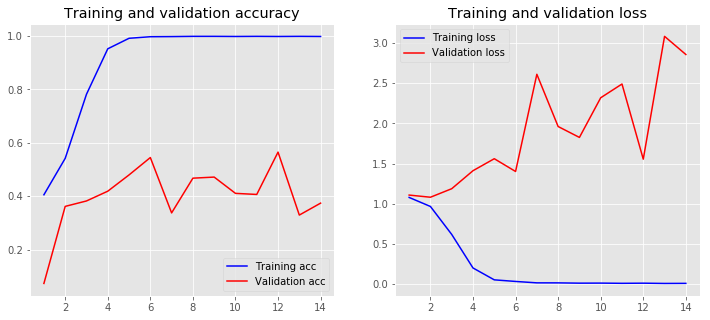

In [60]:
input_shape = (sequence_length,)
model_input = Input(shape=input_shape)
z = Embedding(len(vocabulary_inv), embedding_dim, input_length=sequence_length, name="embedding")(model_input)
# z = Dropout(dropout_prob[0])(z)
conv_blocks = []
# for sz in filter_sizes:
conv = Convolution1D(filters=num_filters,
                     kernel_size=7,
                     padding="valid",
                     activation="relu",
                     strides=1)(z)
conv = MaxPooling1D(pool_size=2)(conv)
conv = Convolution1D(filters=num_filters,
                     kernel_size=5,
                     activation="relu",
                     strides=1)(conv)
conv = MaxPooling1D(pool_size=5)(conv)
conv = Flatten()(conv)
conv_blocks.append(conv)
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

# z = Dropout(dropout_prob[1])(z)
# z = Dense(100, activation="relu")(z)
z = Dense(hidden_dims, activation="relu")(z)
model_output = Dense(3, activation="softmax")(z)

model = Model(model_input, model_output)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
weights = np.array([v for v in embedding_weights.values()])
print("Initializing embedding layer with word2vec weights, shape", weights.shape)
embedding_layer = model.get_layer("embedding")
embedding_layer.set_weights([weights])
model.summary()
# Train the model
history = model.fit(x_train, y, batch_size=batch_size, epochs=num_epochs,
                    validation_split=0.1, verbose=2)
plot_history(history)
# model.save('sentiment_cnn_model.h5')
# model.save_weights('sentiment_cnn_model_weights.h5')

Initializing embedding layer with word2vec weights, shape (35067, 50)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 512, 50)      1753350     input_5[0][0]                    
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 512, 50)      0           embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 510, 10)      1510        dropout_8[0][0]                  
_______________________________________

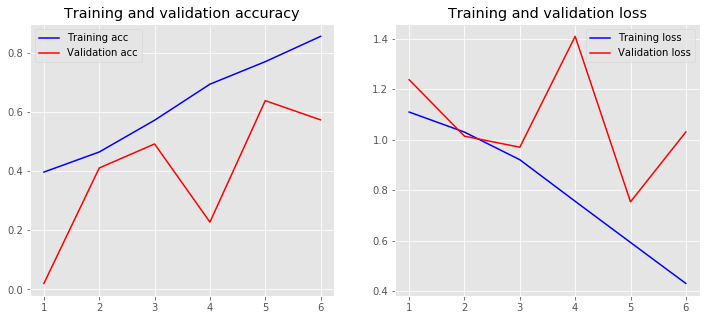

In [37]:
# input_shape = (sequence_length,)
# model_input = Input(shape=input_shape)
# z = Embedding(len(vocabulary_inv), embedding_dim, input_length=sequence_length, name="embedding")(model_input)
# z = Dropout(0.2)(z)
# conv_blocks = []
# for sz in filter_sizes:
#     conv = Convolution1D(filters=num_filters,
#                          kernel_size=sz,
#                          padding="valid",
#                          activation="relu",
#                          strides=1)(z)
#     conv = MaxPooling1D(pool_size=2)(conv)
#     conv = Flatten()(conv)
#     conv_blocks.append(conv)
# z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

# # z = Dropout(dropout_prob[1])(z)
# # z = Dense(100, activation="relu")(z)
# z = Dense(hidden_dims, activation="relu")(z)
# model_output = Dense(3, activation="softmax")(z)

# model = Model(model_input, model_output)
# model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
# weights = np.array([v for v in embedding_weights.values()])
# print("Initializing embedding layer with word2vec weights, shape", weights.shape)
# embedding_layer = model.get_layer("embedding")
# embedding_layer.set_weights([weights])
# model.summary()
# # Train the model
# history = model.fit(x_train, y, batch_size=batch_size, epochs=num_epochs,
#                     validation_split=0.1, verbose=2)
# plot_history(history)

Initializing embedding layer with word2vec weights, shape (42414, 50)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 375)               0         
_________________________________________________________________
embedding (Embedding)        (None, 375, 50)           2120700   
_________________________________________________________________
dropout_13 (Dropout)         (None, 375, 50)           0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 375, 50)           200       
_________________________________________________________________
lstm_3 (LSTM)                (None, 375)               639000    
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 1128      
Total params: 2,761,028
Trainable params: 2,760,928
Non-trainable params

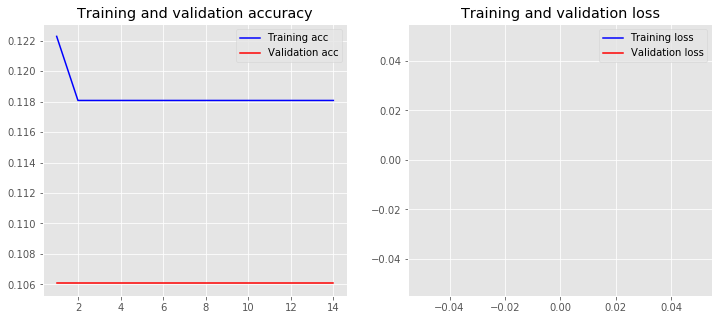

In [48]:
# input_shape = (sequence_length,)
# model_input = Input(shape=input_shape)
# z = Embedding(len(vocabulary_inv), embedding_dim, input_length=sequence_length, name="embedding")(model_input)
# z = Dropout(dropout_prob[0])(z)
# z = BatchNormalization()(z)
# z = LSTM(375, dropout=0.2, recurrent_dropout=0.4,activation='relu')(z)
# model_output = Dense(3, activation="softmax")(z)
# model = Model(model_input, model_output)
# model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
# print("Initializing embedding layer with word2vec weights, shape", weights.shape)
# embedding_layer = model.get_layer("embedding")
# embedding_layer.set_weights([weights])
# model.summary()
# # Train the model
# history = model.fit(x_train, y, batch_size=batch_size, epochs=num_epochs,
#                     validation_split=0.1, verbose=1)
# plot_history(history)

In [61]:
predictions = model.predict(x_test)

In [62]:
predictions = np.argmax(predictions,axis=-1)

In [63]:
predictions

array([1, 1, 2, ..., 1, 2, 1], dtype=int64)

In [36]:
# from keras.models import load_model
# model = load_model('sentiment_cnn_model.h5')
# model.load_weights('sentiment_cnn_model_weights.h5')
# prediction = model.predict(X)

NameError: name 'X' is not defined

In [41]:
len(predictions)

2924

In [42]:
test_data.columns

Index(['unique_hash', 'text', 'drug'], dtype='object')

In [40]:
del submission

NameError: name 'submission' is not defined

In [66]:
# submission = pd.DataFrame(test_data['unique_hash'])
# submission['sentiment'] = pd.Series(predictions)
# submission['sentiment'] = submission['sentiment'].astype('int32')
# submission.columns = ['']
submission.to_csv("cnn_model_d_2.csv",sep=",",index=None)

In [44]:
submission.index=='sentiment'

False

In [45]:
submission

,unique_hash,sentiment
0,9e9a8166b84114aca147bf409f6f956635034c08,2
1,e747e6822c867571afe7b907b51f0f2ca67b0e1a,2
2,50b6d851bcff4f35afe354937949e9948975adf7,2
3,7f82ec2176ae6ab0b5d20b5ffc767ac829f384ae,2
4,8b37d169dee5bdae27060949242fb54feb6a7f7f,2
5,b1950d27d94ceff4e9bf8c7d1fd4b11b35ede4d7,0
6,abafc5b6c5aac6f777cf265e5c7dd80fb793e6bc,2
7,e5550693e72a8335d723ca5fc64da91e1256fb0b,2
8,ee8c500f6402331ff12b0b29d943b6d1699a0b8d,1
9,d261600ba4fc022fac12748845deed56822ff195,2


In [65]:
submission.sentiment.value_counts()

2    1104
1    1029
0     791
Name: sentiment, dtype: int64

In [890]:
# data['text'][17]

In [891]:
# data['text'][17]

In [892]:
# data['text'][5]

In [893]:
# data['text'][11]

In [894]:
# data['text'][20]

In [895]:
# data['text'][6]

In [896]:
# data['text'][10]

In [897]:
# data['text'][89]

In [898]:
# data['text'][56]

In [899]:
# data['text'][1]

In [900]:
# data['text'][5]